In [1]:
#importing libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import requests
style.use('ggplot')

In [2]:
#portfolio value for allocating using crossover 
co_portfolio = 1e5

#portfolio value for allocating using divergence 
div_portfolio = 1e5

#transaction cost as fraction
tscost = 0.005

#list of stocks in portfolio
stock_list = ['BHEL.NS','ITC.NS','LUPIN.NS','RELIANCE.NS','IBVENTURES.NS']

#calculating the no. of stocks in the portfolio
nstocks=0
for stock in stock_list:
    nstocks+=1

In [4]:
#Function to read stock data
def readData(ticker,n):
    df = web.DataReader(ticker, 'yahoo',start='1/1/2015')['Adj Close']
    stocks.append(df)

In [ ]:
#Plotting the stock prices
for ticker in stock_list:
    readData 

In [7]:
#Function to make MACD lines and signal lines
def MACDlines(df):
    df['12 day EMA'] = df['Adj Close'].ewm(span=12).mean()
    df['26 day EMA'] = df['Adj Close'].ewm(span=26).mean()
    #MACD line definition
    df['MACD line'] = df['12 day EMA'] - df['26 day EMA']
    #Signal line calculation
    df['Signal Line'] = df['Adj Close'].ewm(span=9).mean()
    #Initializing positions of crossover and divergence as 0 for each day
    df['cross_pos'] = 0
    df['div_pos'] = 0

In [27]:
#Defines the Position based on a MACD Zero crossover strategy as defined below:

########################################################################################################################
#Entry:  - When MACD line crosses zero line(>0), then long/buy the stock. Similar for squaring off the short position. #
#                                                                                                                      #
#Exit: -   When MACD line crosses zero line(<0), then short/sell the stock. Similar for squaring off the long position.#                           
#                                                                                                                      #
########################################################################################################################


def MACDcross(df1):
    for row in range(len(df1)):
        if(df1['cross_pos'].iloc[row-1]==0):
            if (df1['MACD line'].iloc[row] < 0):
                df1['cross_pos'].iloc[row] = -1

            if (df1['MACD line'].iloc[row] > 0):
                df1['cross_pos'].iloc[row] = 1

            
        elif (df1['cross_pos'].iloc[row-1]==1):
            if (df1['MACD line'].iloc[row] < 0):
                df1['cross_pos'].iloc[row] = 0
            if (df1['MACD line'].iloc[row] > 0):
                df1['cross_pos'].iloc[row] = 1

        else:
            if (df1['MACD line'].iloc[row] > 0):
                df1['cross_pos'].iloc[row] = 0
            if (df1['MACD line'].iloc[row] < 0):
                df1['cross_pos'].iloc[row] = -1

In [28]:
#Defines the position based on a MACD divergence strategy as defined below:

########################################################################################################################
#Entry: MACD forms a lower high but price forms a higher high, go long. Similar for squaring off short position.

#Exit: MACD forms a higher low but price forms a lower low, go short. Similar for squaring off short position.

########################################################################################################################

def divergence(df):
    for row in range(1,len(df)):
        if(df['div_pos'].iloc[row-1]==0):
            if(df['MACD line'].rolling(20).max()[row]<=df['MACD line'].rolling(20).max()[row-1] and 
               df['Adj Close'].rolling(20).max()[row]>df['Adj Close'].rolling(20).max()[row-1]):
                df['div_pos'].iloc[row] = 1
            
            elif(df['MACD line'].rolling(20).min()[row]>=df['MACD line'].rolling(20).min()[row-1] and 
            df['Adj Close'].rolling(20).min()[row]<df['Adj Close'].rolling(20).min()[row-1]):
                df[div_pos].iloc[row] = -1
                
        elif(df['div_pos'].iloc[row-1]==1):
            if(df['MACD line'].rolling(20).min()[row]>=df['MACD line'].rolling(20).min()[row-1] and 
               df['Adj Close'].rolling(20).min()[row]<f['Adj Close'].rolling(20).min()[row-1]):
                df['div_pos'].iloc[row]=0
                
            elif(df['MACD line'].rolling(20).max()[row]<=df['MACD line'].rolling(20).max()[row-1] and 
                 df['Adj Close'].rolling(20).max()[row]>df['Adj Close'].rolling(20).max()[row-1]):
                df['div_pos'].iloc[row]=1
        
        else:
            if(df['MACD line'].rolling(20).min()[row]>=df['MACD line'].rolling(20).min()[row-1] and 
               df['Adj Close'].rolling(20).min()[row]<f['Adj Close'].rolling(20).min()[row-1]):
                df['div_pos'].iloc[row]=-1
                
            elif(df['MACD line'].rolling(20).max()[row]<=df['MACD line'].rolling(20).max()[row-1] and 
                 df['Adj Close'].rolling(20).max()[row]>df['Adj Close'].rolling(20).max()[row-1]):
                df['div_pos'].iloc[row]=0

In [29]:
#Iterating over all the tickers to read data, generate MACD and signal lines and formulate portfolio positions based on strategy
i = 0
stocks = []
for ticker in stock_list:
    readData(ticker,i)
    i+=1

C:\Users\adity\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\adity\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\adity\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\User

In [30]:

# setting the dimensions of the weights vector depending on the available data points
s = (len(stocks[0]),nstocks) 

#Inititializing the weight vector of each stock each day to be 0
co_weights = np.zeros(s)
div_weights = np.zeros(s)

#Giving weights for crossover portfolio
sumwts=0
for row in range(len(stocks[0])):
    
    # Calculating no. of position taken that day
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['cross_pos'].iloc[row]) 
    
    
    #Calculating weights for each day
    for i in range(nstocks):
        if sumwts>0:
            co_weights[row][i]=(co_portfolio*stocks[i]['cross_pos'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+tscost))



#Giving weights for divergence portfolio
sumwts=0
for row in range(len(stocks[0])):
    
    # Calculating no. of position taken that day
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['div_pos'].iloc[row]) 
    
    
    #Calculating weights for each day
    for i in range(nstocks):
        if sumwts>0:
            div_weights[row][i]=(div_portfolio*stocks[i]['div_pos'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+tscost))


            
#Calculating market return
for i in range(nstocks):
    stocks[i]['Market Return'] = (stocks[i]['Adj Close'] - stocks[i]['Adj Close'].shift(1))

    
#Calculating portfolio return for crossover
stocks[0]['Crossover Strategy Return']=0
for i in range(nstocks):
    stocks[0]['Crossover Strategy Return']+=stocks[i]['Market Return'] * co_weights[:,i]

    
    
#Calculating portfolio return for divergence
stocks[0]['Divergence Strategy Return']=0
for i in range(nstocks):
    stocks[0]['Divergence Strategy Return']+=stocks[i]['Market Return'] * div_weights[:,i]

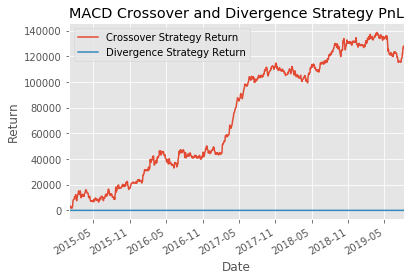

In [31]:
#Plotting both strategy returns
stocks[0]['Crossover Strategy Return'].cumsum().plot(label='Crossover Strategy Return')
stocks[0]['Divergence Strategy Return'].cumsum().plot(label='Divergence Strategy Return')
plt.ylabel('Return')
plt.xlabel('Date')
plt.title('MACD Crossover and Divergence Strategy PnL')
plt.legend()